In [1]:
import torch
import torch_geometric as pyg 
import numpy as np
import kornia

In [2]:
data_list = torch.load("/workspaces/masters_project/notebooks/simplified_gnn_task/gnn_only_dataset.pt")
#turn this into a dataset
data_loader = pyg.loader.DataLoader(data_list, batch_size=128,shuffle=True)

In [68]:
data_loader

In [69]:
main_graph = data_list[0]
main_graph
#join a, b as disconnected graph


Data(x=[50], edge_index=[2, 1225], edge_attr=[1225, 1], pos_one=[50, 2], name_one=[50], original_graph=[100], x_two=[50], edge_index_two=[2, 1225], edge_attr_two=[1225, 1], pos_two=[50, 2], name_two=[50], original_graph_two=[100])

In [70]:
from torch_geometric.nn import SAGEConv, to_hetero, Linear
import torch.nn.functional as F

class GNNModel(torch.nn.Module):

    def __init__(self, hidden_channels):
        super().__init__()
        self.conv1 = SAGEConv(hidden_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.lin = Linear( hidden_channels, 1)
        self.embedding_layer = Linear(1, hidden_channels)
    def forward(self, x, edge_index):
        #embed x to hidden dim 
        x = self.embedding_layer(x.unsqueeze(-1))
        #this is [500, 16]
        #print("initial x: ", x.shape)
        #print("initial, edge_index: ", edge_index.shape)
        #print("initial_edge index max", edge_index.max())
        #initial, edge_index:  torch.Size([2, 12250])
        #initial_edge index max tensor(549)

        x = F.relu(self.conv1(x, edge_index))
        #print("x after conv1: ", x.shape)
        x = self.conv2(x, edge_index)
        #print("x after conv2: ", x.shape)
        edge_x = x[edge_index[0]] *  x[edge_index[1]]
        #print(edge_x.shape)
        return self.lin(edge_x)

In [71]:
class DualNetwork(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.gnnone = GNNModel(hidden_channels)
        self.gnntwo = GNNModel(hidden_channels)
    def forward(self, data):
        x1, edge_index1, edge_attr1 = data.x, data.edge_index, data.edge_attr
        x2, edge_index2, edge_attr2 = data.x_two, data.edge_index_two, data.edge_attr_two
        
        output_1 = self.gnnone(x1, edge_index1)
        output_2 = self.gnntwo(x2, edge_index2)

        #now we will multiply it by the edge_attr
        output_1 = output_1 * edge_attr1
        output_2 = output_2 * edge_attr2
        
        return output_1, output_2

In [72]:
dual_network = DualNetwork(16)

In [73]:
class JSD(torch.nn.Module):
    def __init__(self):
        super(JSD, self).__init__()
        self.kl = torch.nn.KLDivLoss(reduction='batchmean', log_target=True)

    def forward(self, p: torch.tensor, q: torch.tensor):
        p, q = p.view(-1, p.size(-1)), q.view(-1, q.size(-1))
        m = (0.5 * (p + q)).log()
        return 0.5 * (self.kl(m, p.log()) + self.kl(m, q.log()))

In [74]:
#Our embedding 
kl_loss = torch.nn.KLDivLoss(reduction="batchmean", log_target=True)
optimizer = torch.optim.Adam(dual_network.parameters(), lr=0.01)

In [75]:
loss = JSD()

In [76]:
def evaluate_fn(model, val_set, test_set, criterion, 
                use_val_dataset=True ):
    model.eval()
    num_val = 0
    if use_val_dataset:
        dataset_used = val_set
    with torch.no_grad():
        val_loss = []
        for data in dataset_used:
            model_output_1, model_output_2 = model(data)
            max_1 = torch.max(model_output_1)
            max_2 = torch.max(model_output_2)
            max_val = torch.max(max_1, max_2)
            bins = torch.linspace(0, max_val.item(), 30)

            #hist1 = torch.histogram(model_output_1, bins=bins).hist.requires_grad_()
            #hist2 = torch.histogram(model_output_2, bins=bins).hist.requires_grad_()

            hist1 = kornia.enhance.histogram(model_output_1, bins=bins, bandwidth=torch.tensor(0.9))
            hist2 = kornia.enhance.histogram(model_output_2, bins=bins, bandwidth=torch.tensor(0.9))
            loss_val = JSD()(hist1, hist2)
            #hist1 = torch.log(hist1)
            #hist2 = torch.log(hist2)
            #loss_val = kl_loss(hist1, hist2)
            val_loss.append(loss_val.item())
            num_val += data.num_graphs
    #compute the average
        return np.mean(val_loss)
        
        


In [77]:
i.num_graphs

104

In [78]:
loss_array = []
val_loss_array = []
for epoch in range(10):
    val_loss_array.append(evaluate_fn(dual_network, data_loader, data_loader, kl_loss, use_val_dataset=True))

    for i in data_loader:
        optimizer.zero_grad()

      #  print(i)
        model_output = dual_network(i)
        model_output_1, model_output_2 = model_output       
        max_1 = torch.max(model_output_1)
        max_2 = torch.max(model_output_2)
        max_val = torch.max(max_1, max_2)
        bins = torch.linspace(0, max_val.item(), 30)

        #hist1 = torch.histogram(model_output_1, bins=bins).hist.requires_grad_()
        #hist2 = torch.histogram(model_output_2, bins=bins).hist.requires_grad_()

        hist1 = kornia.enhance.histogram(model_output_1, bins=bins, bandwidth=torch.tensor(0.9))
        hist2 = kornia.enhance.histogram(model_output_2, bins=bins, bandwidth=torch.tensor(0.9))
        loss_val = JSD()(hist1, hist2)
        # hist1 = torch.log(hist1)
        # hist2 = torch.log(hist2)
        # loss_val = kl_loss(hist1, hist2)
        loss_val.backward()
        loss_array.append(loss_val.item())
        optimizer.step()

        # a, b = i[0][:, :, 0], i[0][:, :, 1]
        # output_1 = model1(a)
        # output_2 = model2(b)
        
        # model_output_1 = output_1 * a
        # model_output_2 = output_2 * b

        # #take the max of the two outputs
        # max_1 = torch.max(model_output_1)
        # max_2 = torch.max(model_output_2)
        # max_val = torch.max(max_1, max_2)
        # bins = torch.linspace(0, max_val.item(), 30)

        # #hist1 = torch.histogram(model_output_1, bins=bins).hist.requires_grad_()
        # #hist2 = torch.histogram(model_output_2, bins=bins).hist.requires_grad_()

        # hist1 = kornia.enhance.histogram(model_output_1, bins=bins, bandwidth=torch.tensor(0.9))
        # hist2 = kornia.enhance.histogram(model_output_2, bins=bins, bandwidth=torch.tensor(0.9))
        # hist1 = torch.log(hist1)
        # hist2 = torch.log(hist2)
        # loss_val = kl_loss(hist1, hist2)
        # loss_val.backward()
        # loss_array.append(loss_val.item())
        # optimizer.step()

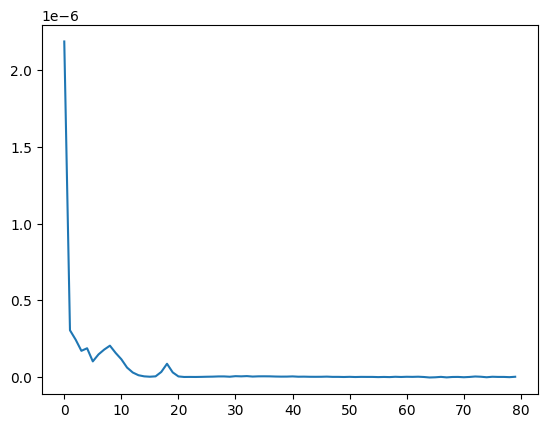

In [79]:
#plot the loss
import matplotlib.pyplot as plt
plt.plot(loss_array)


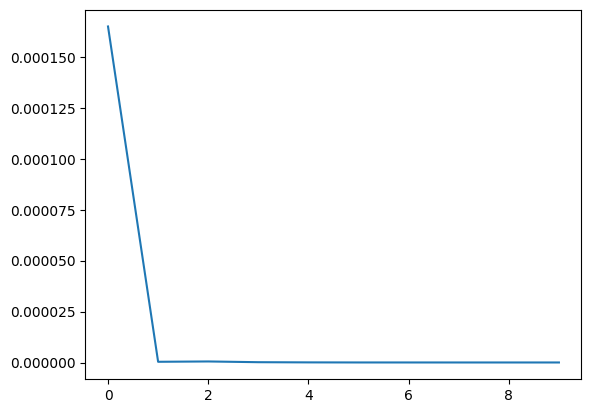

In [47]:
plt.plot(val_loss_array)